In [ ]:
import os
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import re

# Define folder paths (The list of directories where your images are stored)
folder_paths = [
    '/content/drive/MyDrive/dataset/ADNI1_Annual_2_Yr_3T_Not_downloaded_Processed/2D_Slices'
]

# Load the metadata (update this with the correct CSV path)
metadata = pd.read_csv( '/content/drive/MyDrive/dataset/ADNI1_Annual_2_Yr_3T_11_27_2024.csv')

# Example metadata structure: 'Subject', 'Group'
# We will assume that the Group column contains values like 'MCI' or 'Control'.

# Extract patient ID pattern (assuming the format like '136_S_1227')
patient_id_pattern = r'\d{3}_S_\d{4}'  # Regex to match patient IDs like '136_S_1227'

# List the directories in the target folder
folder_list = os.listdir(folder_paths[0])

# Create a list to store matched folder names
matched_folders = []

# Check folder names against patient IDs in metadata
for folder in folder_list:
    # Find all potential patient IDs in the folder name
    matched_patient_ids = re.findall(patient_id_pattern, folder)
    for patient_id in matched_patient_ids:
        if patient_id in metadata['Subject'].values:
            matched_folders.append((patient_id, folder))

# Verify the matched folders
print(f"Matched folders and their patient IDs:\n {matched_folders}")

# Function to load images for a specific patient from the matched folders
def load_patient_images(patient_id, folder_paths):
    images = []
    for folder_path in folder_paths:
        patient_folder = None
        for folder_name in os.listdir(folder_path):
            # Check if the patient ID is a substring of the folder name
            if patient_id in folder_name:
                patient_folder = os.path.join(folder_path, folder_name)  # Found the folder
                break

        # If the folder is found, load the images
        if patient_folder:
            for img_file in os.listdir(patient_folder):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.tif')):  # Include common formats
                    img_path = os.path.join(patient_folder, img_file)
                    img = load_img(img_path, target_size=(224, 224))  # Resize to the CNN input size
                    img_array = img_to_array(img) / 255.0  # Normalize the image to [0, 1]
                    images.append(img_array)
        else:
            print(f"Patient folder not found for {patient_id} in {folder_path}")
    return images


# Ensure data is preprocessed correctly, and split at patient level
from sklearn.model_selection import train_test_split

# Prepare the dataset (X for images, y for labels)
X = []
y = []
patient_ids = []  # Track unique patient IDs for splitting

# Loop through each matched folder and load images and corresponding labels
for patient_id, folder in matched_folders:
    # Get the label from the metadata
    label = metadata.loc[metadata['Subject'] == patient_id, 'Group'].values[0]

    # Load all images for the current patient
    images = load_patient_images(patient_id, folder_paths)

    # Check if images were loaded for this patient
    if images:
        X.extend(images)
        patient_ids.extend([patient_id] * len(images))  # Track patient IDs for each image
        # Convert label (e.g., 'MCI' or 'Control') to numeric
        if label == 'MCI':
            y.extend([1] * len(images))  # Assign 1 for MCI
        else:
            y.extend([0] * len(images))  # Assign 0 for Control (or other labels)
    else:
        print(f"No images found for patient {patient_id}")

# Check if the dataset is empty
if len(X) == 0 or len(y) == 0:
    print("Error: No images or labels were loaded. Please check your data and paths.")
else:
    # Convert X and y to numpy arrays
    X = np.array(X)
    y = np.array(y)
    patient_ids = np.array(patient_ids)

    # Split patients into train and test sets, making sure no patient appears in both sets
    unique_patient_ids = list(set(patient_ids))
    train_patient_ids, test_patient_ids = train_test_split(unique_patient_ids, test_size=0.2, random_state=42)

    # Create train and test datasets by selecting the images based on patient IDs
    X_train, y_train = [], []
    X_test, y_test = [], []

    for i in range(len(patient_ids)):
        if patient_ids[i] in train_patient_ids:
            X_train.append(X[i])
            y_train.append(y[i])
        else:
            X_test.append(X[i])
            y_test.append(y[i])

    # Convert train and test sets to numpy arrays
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    # Check the shapes of the datasets
    print(f'Training images shape: {X_train.shape}')
    print(f'Testing images shape: {X_test.shape}')
    print(f'Training labels shape: {y_train.shape}')
    print(f'Testing labels shape: {y_test.shape}')


Matched folders and their patient IDs:
 [('023_S_0331', '023_S_0331_MPR__GradWarp__B1_Correction__N3__Scaled_2008-03-28_14_12_16.0_I102204_ADNI_023_S_0331_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20080410163445362_S47655_I102204'), ('023_S_0331', '023_S_0331_MPR__GradWarp__B1_Correction__N3__Scaled_2008-03-28_14_12_16.0_I102204_ADNI_023_S_0331_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20080410163445362_S47655_I102204'), ('067_S_0290', '067_S_0290_MPR-R__GradWarp__B1_Correction__N3__Scaled_2007-06-15_13_33_52.0_I72427_ADNI_067_S_0290_MR_MPR-R__GradWarp__B1_Correction__N3__Scaled_Br_20070911104732616_S33684_I72427'), ('067_S_0290', '067_S_0290_MPR-R__GradWarp__B1_Correction__N3__Scaled_2007-06-15_13_33_52.0_I72427_ADNI_067_S_0290_MR_MPR-R__GradWarp__B1_Correction__N3__Scaled_Br_20070911104732616_S33684_I72427'), ('023_S_0061', '023_S_0061_MPR__GradWarp__B1_Correction__N3__Scaled_2006-12-06_10_28_05.0_I81874_ADNI_023_S_0061_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_2007111

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

# Convert labels to one-hot encoding
y_train_onehot = to_categorical(y_train, num_classes=3)
y_test_onehot = to_categorical(y_test, num_classes=3)

# Custom 14-Layer CNN Model
def create_custom_cnn():
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=(224, 224, 3)))

    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(512, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(3, activation='softmax'))  # Output layer (3 classes: AD, MCI, CN)

    model.compile(optimizer=RMSprop(learning_rate=0.00001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Pre-trained models
def create_vgg16():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    predictions = layers.Dense(3, activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=RMSprop(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def create_resnet50():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    predictions = layers.Dense(3, activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=RMSprop(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def create_inceptionv3():
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    predictions = layers.Dense(3, activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=RMSprop(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Model training function
def train_model(model, X_train, y_train, X_test, y_test, epochs=10, batch_size=32):
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))
    return model

# Max Voting Ensemble Function
def max_voting_ensemble(models, X_test):
    # Collect predictions from all models
    predictions = np.zeros((X_test.shape[0], 3))  # Assuming 3 classes
    for model in models:
        pred = model.predict(X_test)
        predictions += pred
    # Return the class with the maximum sum of predicted probabilities
    return np.argmax(predictions, axis=1)

# Create all models


In [ ]:
custom_cnn = create_custom_cnn()
vgg16_model = create_vgg16()
resnet50_model = create_resnet50()
inceptionv3_model = create_inceptionv3()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Train models
custom_cnn = train_model(custom_cnn, X_train, y_train_onehot, X_test, y_test_onehot)


Epoch 1/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.5781 - loss: 0.7614 - val_accuracy: 0.4661 - val_loss: 0.7866
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.6625 - loss: 0.6211 - val_accuracy: 0.4685 - val_loss: 0.8916
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.7082 - loss: 0.5748 - val_accuracy: 0.4190 - val_loss: 1.0653
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.7330 - loss: 0.5317 - val_accuracy: 0.4262 - val_loss: 1.2767
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.7577 - loss: 0.4841 - val_accuracy: 0.4405 - val_loss: 1.1356
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.7965 - loss: 0.4387 - val_accuracy: 0.4821 - val_loss: 1.0835
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.8199 - loss: 0.3971 - val_accuracy: 0.4917 - val_loss: 1.2621
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.8412 - loss: 0.3606 - val_acc

In [ ]:
vgg16_model = train_model(vgg16_model, X_train, y_train_onehot, X_test, y_test_onehot)


Epoch 1/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 46s 73ms/step - accuracy: 0.6430 - loss: 0.6447 - val_accuracy: 0.5399 - val_loss: 1.0067
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 27s 60ms/step - accuracy: 0.8439 - loss: 0.3640 - val_accuracy: 0.5054 - val_loss: 1.4923
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 27s 60ms/step - accuracy: 0.9261 - loss: 0.1949 - val_accuracy: 0.4458 - val_loss: 2.5544
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 27s 59ms/step - accuracy: 0.9679 - loss: 0.1018 - val_accuracy: 0.5881 - val_loss: 1.7523
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 27s 60ms/step - accuracy: 0.9819 - loss: 0.0613 - val_accuracy: 0.5750 - val_loss: 2.2341
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 27s 60ms/step - accuracy: 0.9774 - loss: 0.0723 - val_accuracy: 0.5839 - val_loss: 1.9632
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 27s 59ms/step - accuracy: 0.9927 - loss: 0.0286 - val_accuracy: 0.5762 - val_loss: 2.0921
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 27s 60ms/step - accuracy: 0.9942 - loss: 0.0231 - 

In [ ]:
resnet50_model = train_model(resnet50_model, X_train, y_train_onehot, X_test, y_test_onehot)

Epoch 1/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 73s 65ms/step - accuracy: 0.8030 - loss: 0.4329 - val_accuracy: 0.4643 - val_loss: 1.8896
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 0.9986 - loss: 0.0096 - val_accuracy: 0.4631 - val_loss: 6.1123
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 0.9996 - loss: 0.0017 - val_accuracy: 0.4429 - val_loss: 6.4568
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 1.0000 - loss: 7.0756e-04 - val_accuracy: 0.4488 - val_loss: 3.7516
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 1.0000 - loss: 1.9655e-04 - val_accuracy: 0.5494 - val_loss: 2.9790
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 1.0000 - loss: 1.7688e-04 - val_accuracy: 0.5387 - val_loss: 2.9581
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 1.0000 - loss: 2.8394e-04 - val_accuracy: 0.5149 - val_loss: 3.3077
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 1.0000 -

In [ ]:
inceptionv3_model = train_model(inceptionv3_model, X_train, y_train_onehot, X_test, y_test_onehot)

Epoch 1/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 85s 63ms/step - accuracy: 0.7408 - loss: 0.5622 - val_accuracy: 0.4411 - val_loss: 1.5470
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9931 - loss: 0.0382 - val_accuracy: 0.5488 - val_loss: 1.8909
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9995 - loss: 0.0054 - val_accuracy: 0.5655 - val_loss: 2.2825
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9987 - loss: 0.0044 - val_accuracy: 0.5952 - val_loss: 2.1809
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9999 - loss: 0.0020 - val_accuracy: 0.5702 - val_loss: 2.3789
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9996 - loss: 0.0017 - val_accuracy: 0.6024 - val_loss: 2.3936
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9998 - loss: 0.0010 - val_accuracy: 0.5821 - val_loss: 2.7728
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9993 - loss: 0.0022 - 

In [ ]:
# Evaluate each model
def evaluate_model(model, X_test, y_test):
    y_pred = np.argmax(model.predict(X_test), axis=1)
    y_true = np.argmax(y_test, axis=1)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')


    return accuracy, precision, recall, f1

# Evaluate all models
for model in [custom_cnn, vgg16_model, resnet50_model, inceptionv3_model]:
    acc, prec, rec, f1= evaluate_model(model, X_test, y_test_onehot)
    print(f"Model: {model.name}")
    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}")





105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Model: sequential
Accuracy: 0.4798, Precision: 0.4993, Recall: 0.4798, F1 Score: 0.4464
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
Model: functional_14
Accuracy: 0.5810, Precision: 0.6049, Recall: 0.5810, F1 Score: 0.5722
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
Model: functional_15
Accuracy: 0.5274, Precision: 0.5443, Recall: 0.5274, F1 Score: 0.5182
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step
Model: functional_16
Accuracy: 0.5673, Precision: 0.5788, Recall: 0.5673, F1 Score: 0.5648


In [ ]:
# Max Voting Ensemble Evaluation
ensemble_preds = max_voting_ensemble([vgg16_model, resnet50_model, inceptionv3_model], X_test)

# Compute evaluation metrics for the ensemble
ensemble_accuracy = accuracy_score(np.argmax(y_test_onehot, axis=1), ensemble_preds)
ensemble_precision = precision_score(np.argmax(y_test_onehot, axis=1), ensemble_preds, average='weighted')
ensemble_recall = recall_score(np.argmax(y_test_onehot, axis=1), ensemble_preds, average='weighted')
ensemble_f1 = f1_score(np.argmax(y_test_onehot, axis=1), ensemble_preds, average='weighted')


# Print ensemble metrics
print(f"Ensemble Model:")
print(f"Accuracy: {ensemble_accuracy:.4f}, Precision: {ensemble_precision:.4f}, Recall: {ensemble_recall:.4f}, F1 Score: {ensemble_f1:.4f}")



105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Ensemble Model:
Accuracy: 0.5839, Precision: 0.6086, Recall: 0.5839, F1 Score: 0.5751


In [ ]:
import os
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, roc_auc_score
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Convert X and y to numpy arrays
X = np.array(X)
y = np.array(y)
patient_ids = np.array(patient_ids)

# Split patients into train and test sets
unique_patient_ids = list(set(patient_ids))
train_patient_ids, test_patient_ids = train_test_split(unique_patient_ids, test_size=0.2, random_state=42)

X_train, y_train = [], []
X_test, y_test = [], []

for i in range(len(patient_ids)):
    if patient_ids[i] in train_patient_ids:
        X_train.append(X[i])
        y_train.append(y[i])
    else:
        X_test.append(X[i])
        y_test.append(y[i])

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Image Augmentation to prevent overfitting
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator()

train_datagen.fit(X_train)
test_datagen.fit(X_test)

# Convert labels to one-hot encoding
y_train_onehot = to_categorical(y_train, num_classes=2)  # 2 classes: MCI or Control
y_test_onehot = to_categorical(y_test, num_classes=2)


In [ ]:
import os
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:

# Use pre-trained models with fine-tuning
def create_vgg16():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False  # Freeze base model layers
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    predictions = layers.Dense(2, activation='softmax')(x)  # 2 output classes
    model = models.Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def create_resnet50():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    predictions = layers.Dense(2, activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def create_inceptionv3():
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    predictions = layers.Dense(2, activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Training function with early stopping and learning rate reduction
def train_model(model, X_train, y_train, X_test, y_test, epochs=20, batch_size=32):
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test),
                        callbacks=[early_stop, reduce_lr])
    return model

# Example: Train VGG16 model
vgg16_model = create_vgg16()
vgg16_model = train_model(vgg16_model, X_train, y_train_onehot, X_test, y_test_onehot, epochs=20, batch_size=32)

# Evaluate model performance (AUC, Precision, Recall, F1 Score)
y_pred = vgg16_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Evaluate metrics
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)
roc_auc = roc_auc_score(y_test_onehot, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC: {roc_auc}")

Epoch 1/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - accuracy: 0.5817 - loss: 0.6855 - val_accuracy: 0.5149 - val_loss: 0.7050 - learning_rate: 1.0000e-04
Epoch 2/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.6480 - loss: 0.6338 - val_accuracy: 0.4935 - val_loss: 0.7410 - learning_rate: 1.0000e-04
Epoch 3/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.6756 - loss: 0.6126 - val_accuracy: 0.5113 - val_loss: 0.7647 - learning_rate: 1.0000e-04
Epoch 4/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.6955 - loss: 0.5928 - val_accuracy: 0.5089 - val_loss: 0.7807 - learning_rate: 1.0000e-04
Epoch 5/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.7066 - loss: 0.5804 - val_accuracy: 0.5310 - val_loss: 0.7682 - learning_rate: 5.0000e-05
Epoch 6/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.7137 - loss: 0.5749 - val_accuracy: 0.5226 - val_loss: 0.7911 - learning_rate: 5.0000e-05
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
Accuracy: 

In [ ]:
def create_custom_cnn():
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=(224, 224, 3)))

    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(512, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(2, activation='softmax'))  # Output layer (2 classes)

    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


custom_cnn = create_custom_cnn()
custom_cnn = train_model(custom_cnn, X_train, y_train_onehot, X_test, y_test_onehot, epochs=20, batch_size=32)

# Evaluate model performance (AUC, Precision, Recall, F1 Score)
y_pred = custom_cnn.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Evaluate metrics
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)
roc_auc = roc_auc_score(y_test_onehot, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC: {roc_auc}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.6485 - loss: 0.5976 - val_accuracy: 0.4679 - val_loss: 2.1357 - learning_rate: 1.0000e-04
Epoch 2/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9495 - loss: 0.1367 - val_accuracy: 0.5357 - val_loss: 3.4253 - learning_rate: 1.0000e-04
Epoch 3/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9999 - loss: 0.0032 - val_accuracy: 0.5143 - val_loss: 5.0200 - learning_rate: 1.0000e-04
Epoch 4/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 1.0000 - loss: 2.4706e-04 - val_accuracy: 0.5250 - val_loss: 5.4371 - learning_rate: 1.0000e-04
Epoch 5/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 1.0000 - loss: 1.0199e-04 - val_accuracy: 0.5250 - val_loss: 5.6727 - learning_rate: 5.0000e-05
Epoch 6/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 1.0000 - loss: 7.5163e-05 - val_accuracy: 0.5250 - val_loss: 5.8606 - learning_rate: 5.0000e-05
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Accu

In [ ]:
resnet_model = create_resnet50()
resnet_model = train_model(resnet_model, X_train, y_train_onehot, X_test, y_test_onehot, epochs=20, batch_size=32)

# Evaluate model performance (AUC, Precision, Recall, F1 Score)
y_pred = resnet_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Evaluate metrics
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)
roc_auc = roc_auc_score(y_test_onehot, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC: {roc_auc}")

Epoch 1/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 26s 38ms/step - accuracy: 0.5322 - loss: 0.7065 - val_accuracy: 0.4179 - val_loss: 0.7196 - learning_rate: 1.0000e-04
Epoch 2/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.5665 - loss: 0.6772 - val_accuracy: 0.4673 - val_loss: 0.7614 - learning_rate: 1.0000e-04
Epoch 3/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.5939 - loss: 0.6663 - val_accuracy: 0.4268 - val_loss: 0.7191 - learning_rate: 1.0000e-04
Epoch 4/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.5955 - loss: 0.6620 - val_accuracy: 0.4643 - val_loss: 0.8222 - learning_rate: 1.0000e-04
Epoch 5/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.6150 - loss: 0.6537 - val_accuracy: 0.4923 - val_loss: 0.7515 - learning_rate: 1.0000e-04
Epoch 6/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.6228 - loss: 0.6452 - val_accuracy: 0.4881 - val_loss: 0.7847 - learning_rate: 1.0000e-04
Epoch 7/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/ste

In [ ]:

inseption_model = create_inceptionv3()
inseption_model = train_model(inseption_model, X_train, y_train_onehot, X_test, y_test_onehot, epochs=20, batch_size=32)

# Evaluate model performance (AUC, Precision, Recall, F1 Score)
y_pred = inseption_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Evaluate metrics
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)
roc_auc = roc_auc_score(y_test_onehot, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC: {roc_auc}")

Epoch 1/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 27s 38ms/step - accuracy: 0.6714 - loss: 0.6047 - val_accuracy: 0.4304 - val_loss: 1.0463 - learning_rate: 1.0000e-04
Epoch 2/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.8341 - loss: 0.3990 - val_accuracy: 0.4690 - val_loss: 1.1450 - learning_rate: 1.0000e-04
Epoch 3/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.8868 - loss: 0.3089 - val_accuracy: 0.4738 - val_loss: 1.2547 - learning_rate: 1.0000e-04
Epoch 4/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9307 - loss: 0.2290 - val_accuracy: 0.4637 - val_loss: 1.3473 - learning_rate: 1.0000e-04
Epoch 5/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9572 - loss: 0.1734 - val_accuracy: 0.4619 - val_loss: 1.3818 - learning_rate: 5.0000e-05
Epoch 6/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9717 - loss: 0.1448 - val_accuracy: 0.4833 - val_loss: 1.4243 - learning_rate: 5.0000e-05
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step
Accuracy: 0.430

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Training Custom CNN...
Epoch 1/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.6523 - loss: 0.6057 - val_accuracy: 0.5810 - val_loss: 1.4079 - learning_rate: 1.0000e-04
Epoch 2/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9536 - loss: 0.1267 - val_accuracy: 0.5214 - val_loss: 3.4453 - learning_rate: 1.0000e-04
Epoch 3/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9980 - loss: 0.0078 - val_accuracy: 0.5411 - val_loss: 4.2695 - learning_rate: 1.0000e-04
Epoch 4/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 1.0000 - loss: 3.2506e-04 - val_accuracy: 0.5446 - val_loss: 4.8904 - learning_rate: 1.0000e-04
Epoch 5/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 1.0000 - loss: 1.0011e-04 - val_accuracy: 0.5417 - val_loss: 5.0992 - learning_rate: 5.0000e-05
Epoch 6/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 1.0000 - loss: 7.2110e-05 - val_accuracy: 0.5405 - val_loss: 5.2161 - learning_rate: 5.0000e-05
Training VGG16...
Epoc

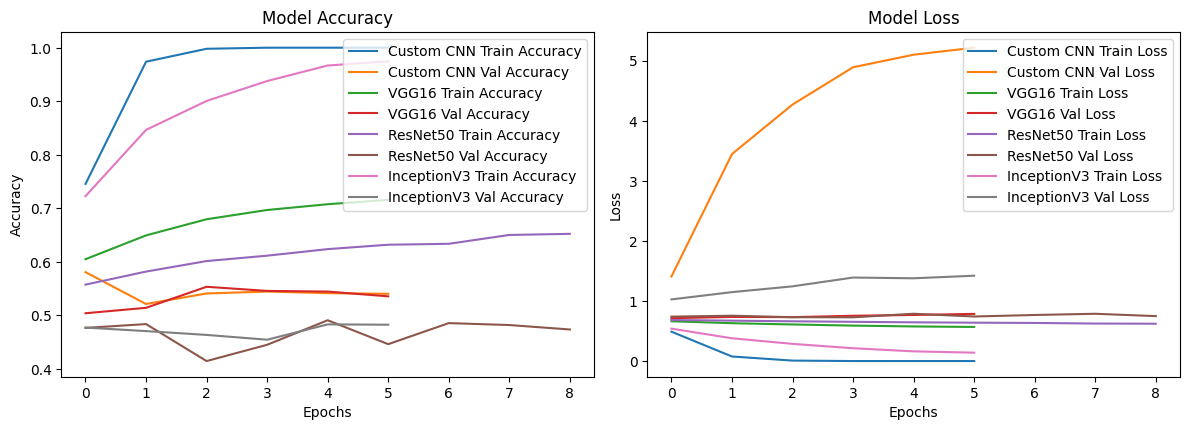

In [ ]:
# Convert X and y to numpy arrays
X = np.array(X)
y = np.array(y)
patient_ids = np.array(patient_ids)

# Split patients into train and test sets
unique_patient_ids = list(set(patient_ids))
train_patient_ids, test_patient_ids = train_test_split(unique_patient_ids, test_size=0.2, random_state=42)

X_train, y_train = [], []
X_test, y_test = [], []

for i in range(len(patient_ids)):
    if patient_ids[i] in train_patient_ids:
        X_train.append(X[i])
        y_train.append(y[i])
    else:
        X_test.append(X[i])
        y_test.append(y[i])

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Image Augmentation to prevent overfitting
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator()

train_datagen.fit(X_train)
test_datagen.fit(X_test)

# Convert labels to one-hot encoding
y_train_onehot = to_categorical(y_train, num_classes=2)  # 2 classes: MCI or Control
y_test_onehot = to_categorical(y_test, num_classes=2)

# Define model creation functions (Custom CNN, VGG16, ResNet50, InceptionV3)
def create_custom_cnn():
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=(224, 224, 3)))

    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(512, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(2, activation='softmax'))  # Output layer (2 classes)

    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Use pre-trained models with fine-tuning
def create_vgg16():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False  # Freeze base model layers
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    predictions = layers.Dense(2, activation='softmax')(x)  # 2 output classes
    model = models.Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def create_resnet50():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False  # Freeze base model layers
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    predictions = layers.Dense(2, activation='softmax')(x)  # 2 output classes
    model = models.Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def create_inceptionv3():
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False  # Freeze base model layers
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    predictions = layers.Dense(2, activation='softmax')(x)  # 2 output classes
    model = models.Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define model training function
def train_model(model, X_train, y_train, X_test, y_test, epochs=20, batch_size=32):
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test),
                        callbacks=[early_stop, reduce_lr])
    return model, history

# Train models and store results
models_dict = {
    "Custom CNN": create_custom_cnn(),
    "VGG16": create_vgg16(),
    "ResNet50": create_resnet50(),
    "InceptionV3": create_inceptionv3()
}

model_histories = {}

for model_name, model in models_dict.items():
    print(f"Training {model_name}...")
    model, history = train_model(model, X_train, y_train_onehot, X_test, y_test_onehot, epochs=20, batch_size=32)
    model_histories[model_name] = history

# Ensemble: Majority Voting
def ensemble_predict(models, X_test):
    # Get predictions from each model
    predictions = np.zeros((X_test.shape[0], 2))  # Initialize array for predictions
    for model in models:
        preds = model.predict(X_test)
        predictions += preds  # Sum the predictions from all models

    # Return the predicted class based on majority voting
    return np.argmax(predictions, axis=1)

# Perform ensemble prediction on the test set
ensemble_predictions = ensemble_predict(list(models_dict.values()), X_test)

# Evaluate ensemble model
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
ensemble_precision = precision_score(y_test, ensemble_predictions)
ensemble_recall = recall_score(y_test, ensemble_predictions)
ensemble_f1 = f1_score(y_test, ensemble_predictions)

print(f"Ensemble Model - Accuracy: {ensemble_accuracy:.4f}")
print(f"Ensemble Model - Precision: {ensemble_precision:.4f}")
print(f"Ensemble Model - Recall: {ensemble_recall:.4f}")
print(f"Ensemble Model - F1 Score: {ensemble_f1:.4f}")

# Plot performance curves for individual models and the ensemble model
plt.figure(figsize=(12, 8))

# Individual model curves
for model_name, history in model_histories.items():
    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'], label=f'{model_name} Train Accuracy')
    plt.plot(history.history['val_accuracy'], label=f'{model_name} Val Accuracy')

    plt.subplot(2, 2, 2)
    plt.plot(history.history['loss'], label=f'{model_name} Train Loss')
    plt.plot(history.history['val_loss'], label=f'{model_name} Val Loss')

# Ensemble accuracy curve (optional, just showing ensemble final performance)
plt.subplot(2, 2, 1)
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 2)
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

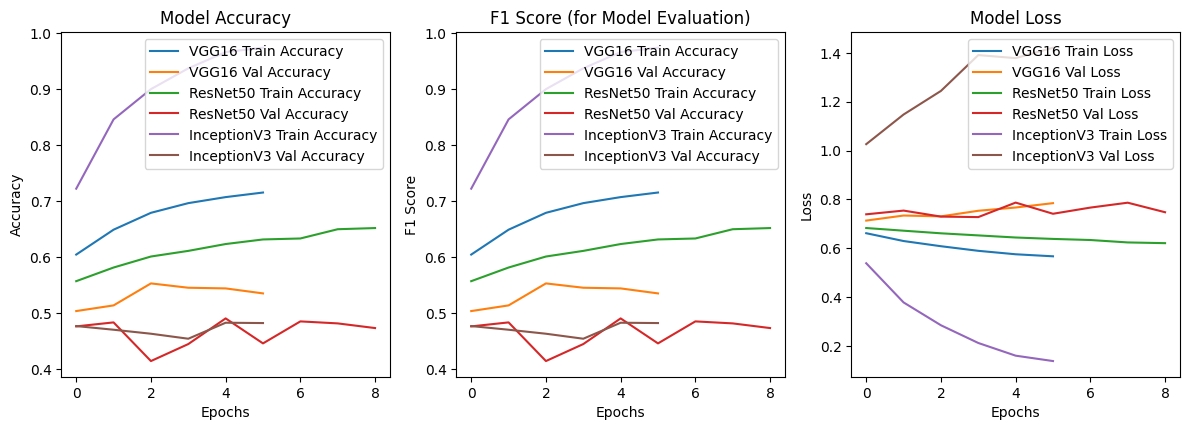

y_test_bin shape: (3360,)
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Model prediction shape: (3360, 2)
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
Model prediction shape: (3360, 2)
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
Model prediction shape: (3360, 2)
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Model prediction shape: (3360, 2)
Ensemble Probabilities Shape: (3360, 2)
Ensemble ROC AUC Score: 0.5384


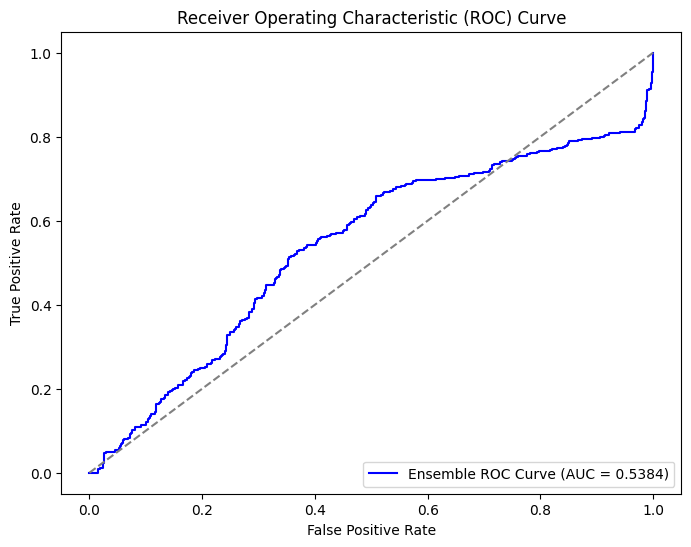

Ensemble Model - Accuracy: 0.5750
Ensemble Model - F1 Score: 0.5498
Ensemble Model - Loss: 0.9690


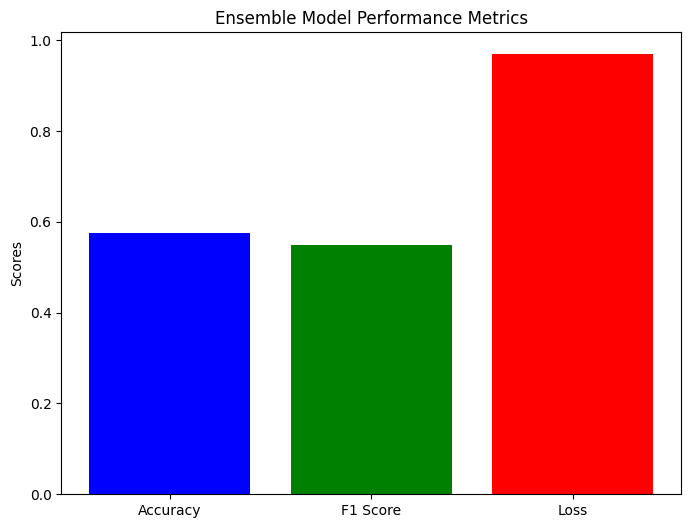

105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
VGG16 prediction shape: (3360, 2)
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
ResNet50 prediction shape: (3360, 2)
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
InceptionV3 prediction shape: (3360, 2)


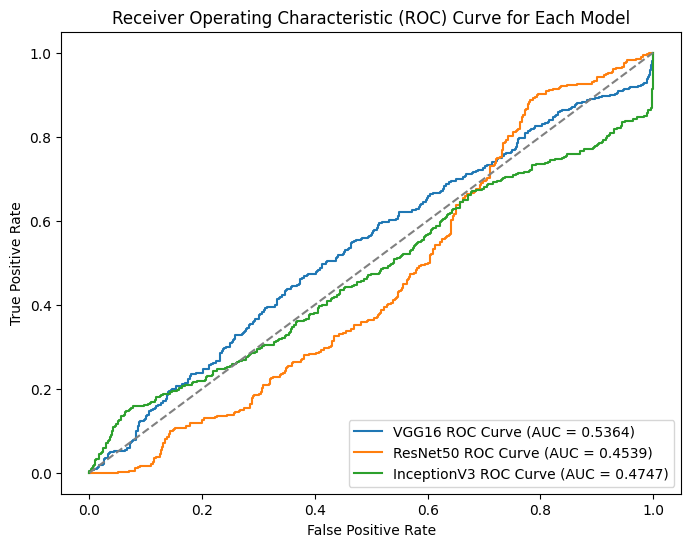

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

# 1. Plot Accuracy, F1 Score, and Loss over Epochs (excluding Custom CNN)
plt.figure(figsize=(12, 8))

for model_name, history in model_histories.items():
    if model_name != "Custom CNN":  # Exclude Custom CNN from the plot
        # Accuracy plot
        plt.subplot(2, 3, 1)
        plt.plot(history.history['accuracy'], label=f'{model_name} Train Accuracy')
        plt.plot(history.history['val_accuracy'], label=f'{model_name} Val Accuracy')

        # F1 Score plot (we'll calculate and plot it for each model using validation data)
        plt.subplot(2, 3, 2)
        plt.plot(history.history['accuracy'], label=f'{model_name} Train Accuracy')
        plt.plot(history.history['val_accuracy'], label=f'{model_name} Val Accuracy')

        # Loss plot
        plt.subplot(2, 3, 3)
        plt.plot(history.history['loss'], label=f'{model_name} Train Loss')
        plt.plot(history.history['val_loss'], label=f'{model_name} Val Loss')

# Plotting settings for accuracy, f1 score, and loss
plt.subplot(2, 3, 1)
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 3, 2)
plt.title('F1 Score (for Model Evaluation)')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.subplot(2, 3, 3)
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 2. Calculate ROC AUC Score for Ensemble (using predicted probabilities)
# Ensure y_test_bin is a 1D array for ROC AUC calculation
y_test_bin = y_test  # Use original binary labels (not one-hot encoded)

print(f"y_test_bin shape: {y_test_bin.shape}")  # Debugging the shape of y_test_bin

# Get probabilities from ensemble prediction (predictions from all models)
ensemble_probabilities = np.zeros((X_test.shape[0], 2))  # Initialize array for probabilities (2 columns for binary classes)
for model in models_dict.values():
    prob = model.predict(X_test)
    print(f"Model prediction shape: {prob.shape}")  # Debugging each model's prediction shape
    ensemble_probabilities += prob  # Sum the probabilities from all models

ensemble_probabilities /= len(models_dict)  # Average the predictions (ensemble)

# Check if ensemble_probabilities has the correct shape
print(f"Ensemble Probabilities Shape: {ensemble_probabilities.shape}")

# Check if the model outputs probabilities and not class labels
if ensemble_probabilities.shape[1] != 2:
    print("Warning: Model may not be outputting probabilities with 2 columns. Please check the model output.")

# Initialize ensemble_auc with a default value (None)
ensemble_auc = None

# Calculate ROC AUC score - we use class 1 probabilities (positive class)
try:
    ensemble_auc = roc_auc_score(y_test_bin, ensemble_probabilities[:, 1])  # Use class 1 (positive class) probabilities
    print(f"Ensemble ROC AUC Score: {ensemble_auc:.4f}")
except Exception as e:
    print(f"Error calculating Ensemble ROC AUC: {e}")

# Plot ROC curve if ensemble_auc is calculated
if ensemble_auc is not None:
    fpr, tpr, _ = roc_curve(y_test_bin, ensemble_probabilities[:, 1])  # Positive class (class 1)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='b', label=f'Ensemble ROC Curve (AUC = {ensemble_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

# 3. Plot the Ensemble Model Metrics (Accuracy, F1, Loss, AUC)
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
ensemble_f1 = f1_score(y_test, ensemble_predictions)
ensemble_loss = np.mean([model.evaluate(X_test, y_test_onehot, verbose=0)[0] for model in models_dict.values()])  # Average loss

print(f"Ensemble Model - Accuracy: {ensemble_accuracy:.4f}")
print(f"Ensemble Model - F1 Score: {ensemble_f1:.4f}")
print(f"Ensemble Model - Loss: {ensemble_loss:.4f}")

# Plotting summary metrics
plt.figure(figsize=(8, 6))
metrics = ['Accuracy', 'F1 Score', 'Loss']
values = [ensemble_accuracy, ensemble_f1, ensemble_loss]

plt.bar(metrics, values, color=['blue', 'green', 'red'])
plt.title('Ensemble Model Performance Metrics')
plt.ylabel('Scores')
plt.show()

# 4. Plot the ROC Curve for each model (excluding Custom CNN)
plt.figure(figsize=(8, 6))

for model_name, model in models_dict.items():
    if model_name != "Custom CNN":  # Exclude Custom CNN from the plot
        # Get predicted probabilities for the model
        model_prob = model.predict(X_test)
        print(f"{model_name} prediction shape: {model_prob.shape}")  # Debugging each model's prediction shape
        fpr, tpr, _ = roc_curve(y_test_bin, model_prob[:, 1])  # Positive class (class 1)
        auc = roc_auc_score(y_test_bin, model_prob[:, 1])
        plt.plot(fpr, tpr, label=f'{model_name} ROC Curve (AUC = {auc:.4f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve for Each Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()
